# Tiny Imagenet

In [ ]:
import os
# os.environ['CUDA_VISIBLE_DEVICES']='1'

In [ ]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from torchvision.io import read_image,ImageReadMode

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.training import *

In [ ]:
from fastprogress import progress_bar
from glob import glob

In [ ]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Data processing

In [ ]:
path = Path.home()/'data'/'tiny-imagenet-200'
bs = 512
# bs = 32
xmean,xstd = (tensor([0.47565, 0.40303, 0.31555]), tensor([0.28858, 0.24402, 0.26615]))

In [ ]:
tfms = nn.Sequential(T.Pad(8), T.RandomCrop(64), T.RandomHorizontalFlip())

In [ ]:
class TinyDS:
    def __init__(self, path):
        self.path = Path(path)
        self.files = glob(str(path/'**/*.JPEG'), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        img = read_image(self.files[i], mode=ImageReadMode.RGB)/255
        return tfms((img-xmean[:,None,None])/xstd[:,None,None])

class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        item = self.ds[i]
        return self.tfmx(item),self.tfmy(item)

def denorm(x): return (x*xstd[:,None,None]+xmean[:,None,None]).clamp(0,1)

In [ ]:
def tfmx(x, erase=True):
    x = TF.resize(x, (32,32))[None]
    x = F.interpolate(x, scale_factor=2)
    if erase: x = rand_erase(x)
    return x[0]

In [ ]:
tds = TinyDS(path/'train')
vds = TinyDS(path/'val')

tfm_tds = TfmDS(tds, tfmx)
tfm_vds = TfmDS(vds, partial(tfmx, erase=False))

dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=8))

In [ ]:
xb,yb = next(iter(dls.train))

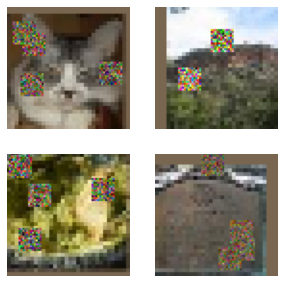

In [ ]:
show_images(denorm(xb[:4]), imsize=2.5)

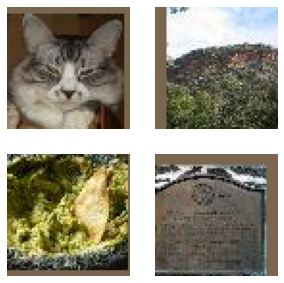

In [ ]:
show_images(denorm(yb[:4]), imsize=2.5)

## Denoising autoencoder

In [ ]:
def up_block(ni, nf, ks=3, act=act_gr, norm=None):
    return nn.Sequential(nn.UpsamplingNearest2d(scale_factor=2),
                         ResBlock(ni, nf, ks=ks, act=act, norm=norm))

In [ ]:
def get_model(act=act_gr, nfs=(32,64,128,256,512,1024), norm=nn.BatchNorm2d, drop=0.1):
    layers = [ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [up_block(nfs[i], nfs[i-1], act=act, norm=norm) for i in range(len(nfs)-1,0,-1)]
    layers += [ResBlock(nfs[0], 3, act=nn.Identity, norm=norm)]
    return nn.Sequential(*layers).apply(iw)

In [ ]:
iw = partial(init_weights, leaky=0.1)

In [ ]:
metrics = MetricsCB()
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]
lr_cbs = [DeviceCB(), ProgressCB(), MixedPrecision()]
opt_func = partial(optim.AdamW, eps=1e-5)

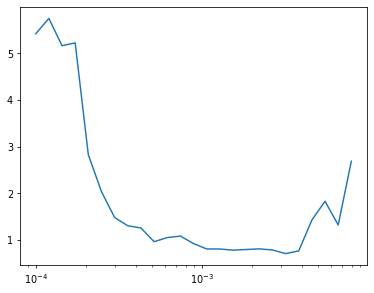

In [ ]:
Learner(get_model().apply(iw), dls, F.mse_loss, cbs=lr_cbs, opt_func=opt_func).lr_find(start_lr=1e-4, gamma=1.2)

In [ ]:
epochs = 5
lr = 1e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(get_model().apply(iw), dls, F.mse_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.584,0,train
0.361,0,eval
0.314,1,train
0.268,1,eval
0.252,2,train
0.225,2,eval
0.228,3,train
0.211,3,eval
0.220,4,train
0.207,4,eval


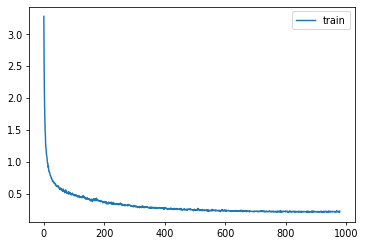

In [ ]:
learn.fit(epochs)

In [ ]:
p,t,inp = learn.capture_preds(inps=True)

loss,epoch,train
0.207,0,eval


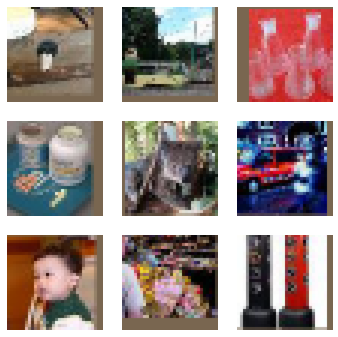

In [ ]:
show_images(denorm(inp[:9]), imsize=2)

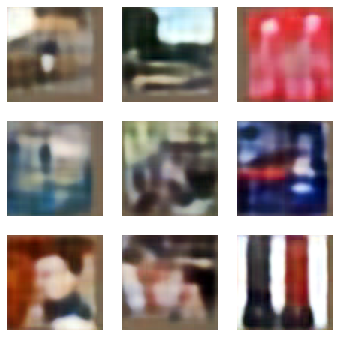

In [ ]:
show_images(denorm(p[:9]), imsize=2)

## Unet

In [ ]:
del(learn)
clean_mem()

In [ ]:
class TinyUnet(nn.Module):
    def __init__(self, act=act_gr, nfs=(32,64,128,256,512,1024), norm=nn.BatchNorm2d):
        super().__init__()
        self.start = ResBlock(3, nfs[0], stride=1, act=act, norm=norm)
        self.dn = nn.ModuleList([ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
                                 for i in range(len(nfs)-1)])
        self.up = nn.ModuleList([up_block(nfs[i], nfs[i-1], act=act, norm=norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.up += [ResBlock(nfs[0], 3, act=act, norm=norm)]
        self.end = ResBlock(3, 3, act=nn.Identity, norm=norm)

    def forward(self, x):
        layers = []
        layers.append(x)
        x = self.start(x)
        for l in self.dn:
            layers.append(x)
            x = l(x)
        n = len(layers)
        for i,l in enumerate(self.up):
            if i!=0: x += layers[n-i]
            x = l(x)
        return self.end(x+layers[0])

In [ ]:
def zero_wgts(l):
    with torch.no_grad():
        l.weight.zero_()
        l.bias.zero_()

In [ ]:
model = TinyUnet()

In [ ]:
last_res = model.up[-1]
zero_wgts(last_res.convs[-1][-1])
zero_wgts(last_res.idconv[0])
zero_wgts(model.end.convs[-1][-1])

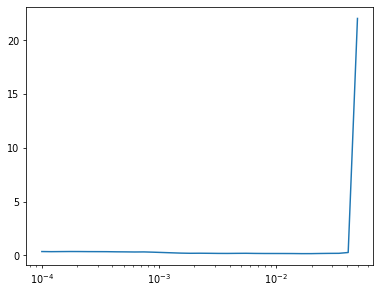

In [ ]:
Learner(model, dls, F.mse_loss, cbs=lr_cbs, opt_func=opt_func).lr_find(start_lr=1e-4, gamma=1.2)

In [ ]:
model = TinyUnet()

In [ ]:
last_res = model.up[-1]
zero_wgts(last_res.convs[-1][-1])
zero_wgts(last_res.idconv[0])
zero_wgts(model.end.convs[-1][-1])

In [ ]:
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, F.mse_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.163,0,train
0.086,0,eval
0.107,1,train
0.082,1,eval
0.097,2,train
0.080,2,eval
0.094,3,train
0.079,3,eval
0.092,4,train
0.077,4,eval


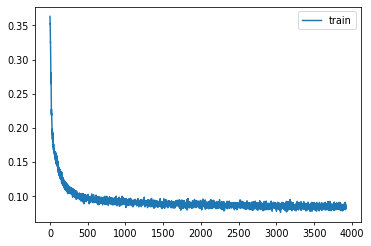

In [ ]:
learn.fit(epochs)

In [ ]:
p,t,inp = learn.capture_preds(inps=True)

loss,epoch,train
0.073,0,eval


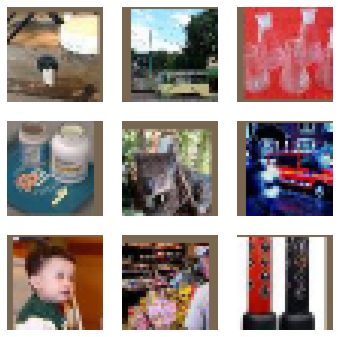

In [ ]:
show_images(denorm(inp[:9]), imsize=2)

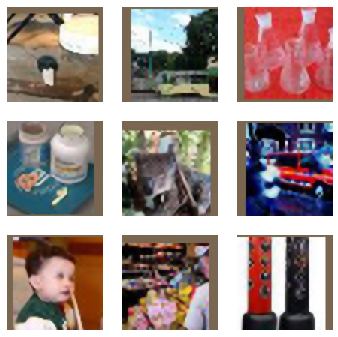

In [ ]:
show_images(denorm(p[:9]), imsize=2)

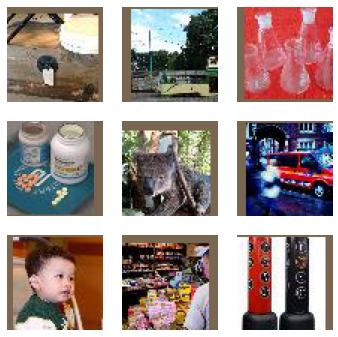

In [ ]:
show_images(denorm(t[:9]), imsize=2)

## Perceptual loss

In [ ]:
# del(learn)
# clean_mem()

In [ ]:
cmodel = torch.load('models/inettiny-custom-25').cuda()

In [ ]:
xb,yb = next(iter(dls.valid))
with torch.autocast('cuda'),torch.no_grad(): preds = to_cpu(cmodel(yb.cuda().half()))
preds.shape

torch.Size([1024, 200])

In [ ]:
id2str = (path/'wnids.txt').read_text().splitlines()
all_synsets = [o.split('\t') for o in (path/'words.txt').read_text().splitlines()]
synsets = {k:v.split(',', maxsplit=1)[0] for k,v in all_synsets if k in id2str}

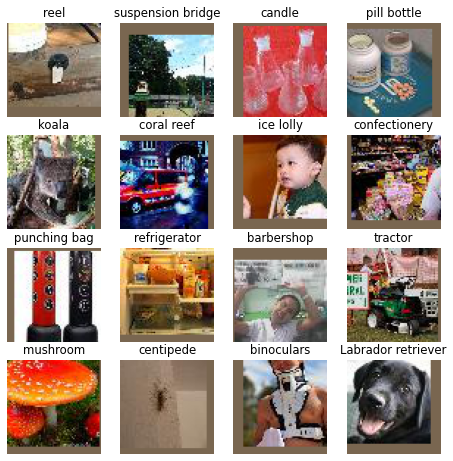

In [ ]:
titles = [synsets[id2str[o]] for o in preds.argmax(dim=1)]
show_images(denorm(yb[:16]), imsize=2, titles=titles[:16])

In [ ]:
for i in range(4,len(cmodel)): del(cmodel[4])

In [ ]:
learn.model = torch.load('models/superres-cross.pkl')

In [ ]:
with torch.autocast('cuda'),torch.no_grad():
    feat = to_cpu(cmodel(yb.cuda())).float()
    t = to_cpu(learn.model(yb.cuda())).float()
    pred_feat = to_cpu(cmodel(t.cuda())).float()

feat.shape

torch.Size([1024, 256, 8, 8])

In [ ]:
def comb_loss(inp, tgt):
    with torch.autocast('cuda'):
        with torch.no_grad(): tgt_feat = cmodel(tgt).float()
        inp_feat = cmodel(inp).float()
    feat_loss = F.mse_loss(inp_feat, tgt_feat)
    return F.mse_loss(inp,tgt) + feat_loss/10

In [ ]:
def get_unet():
    model = TinyUnet()
    last_res = model.up[-1]
    zero_wgts(last_res.convs[-1][-1])
    zero_wgts(last_res.idconv[0])
    zero_wgts(model.end.convs[-1][-1])
    return model

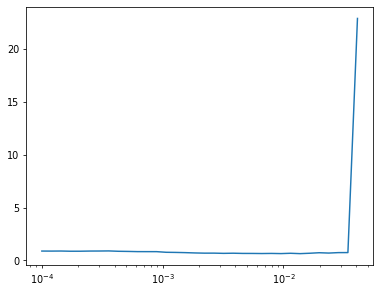

In [ ]:
Learner(get_unet(), dls, comb_loss, cbs=lr_cbs, opt_func=opt_func).lr_find(start_lr=1e-4, gamma=1.2)

In [ ]:
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(get_unet(), dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.602,0,train
0.385,0,eval
0.477,1,train
0.354,1,eval
0.434,2,train
0.348,2,eval
0.415,3,train
0.343,3,eval
0.404,4,train
0.337,4,eval


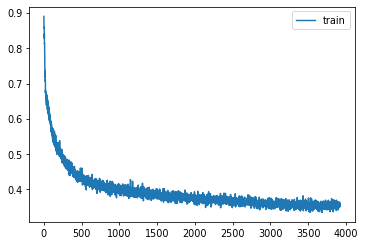

In [ ]:
learn.fit(epochs)

In [ ]:
p,t,inp = learn.capture_preds(inps=True)

loss,epoch,train
0.303,0,eval


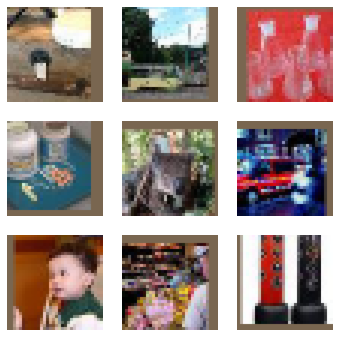

In [ ]:
show_images(denorm(inp[:9]), imsize=2)

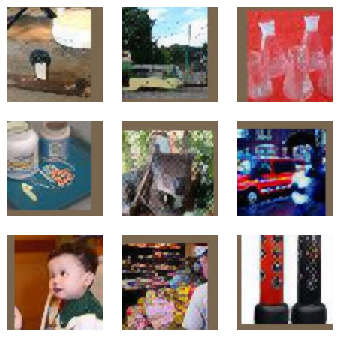

In [ ]:
show_images(denorm(p[:9]), imsize=2)

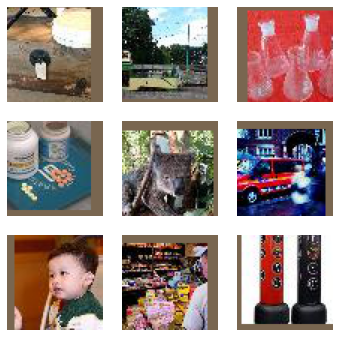

In [ ]:
show_images(denorm(t[:9]), imsize=2)

## Perceptual loss

In [ ]:
model = get_unet()

In [ ]:
pmodel = torch.load('models/inettiny-custom-25')
model.start.load_state_dict(pmodel[0].state_dict())
for i in range(5): model.dn[i].load_state_dict(pmodel[i+1].state_dict())

In [ ]:
for o in model.dn.parameters(): o.requires_grad_(False)

In [ ]:
epochs = 1
lr = 3e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.444,0,train
0.255,0,eval


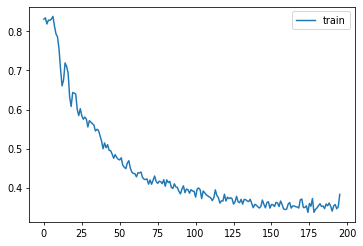

In [ ]:
learn.fit(epochs)

In [ ]:
for o in model.dn.parameters(): o.requires_grad_(True)

In [ ]:
epochs = 20
lr = 3e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.344,0,train
0.249,0,eval
0.327,1,train
0.246,1,eval
0.309,2,train
0.252,2,eval
0.296,3,train
0.243,3,eval
0.287,4,train
0.226,4,eval


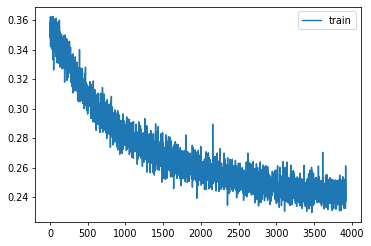

In [ ]:
learn.fit(epochs)

In [ ]:
torch.save(learn.model, 'models/superres-pcp.pkl')
# learn.model = torch.load('models/superres-pcp.pkl').cuda()

In [ ]:
p,t,inp = learn.capture_preds(inps=True)

loss,epoch,train
0.198,0,eval


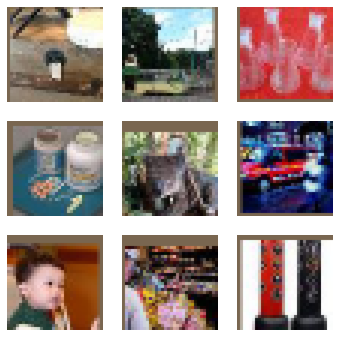

In [ ]:
show_images(denorm(inp[:9]), imsize=2)

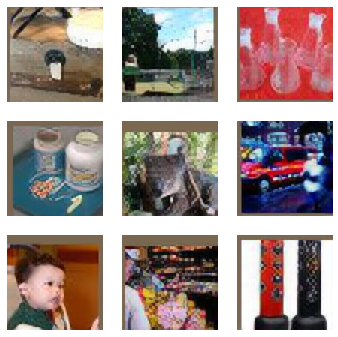

In [ ]:
show_images(denorm(p[:9]), imsize=2)

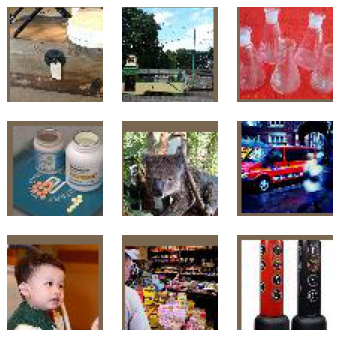

In [ ]:
show_images(denorm(t[:9]), imsize=2)

In [ ]:
torch.save(learn.model, 'models/superres-pcp.pkl')
# learn.model = torch.load('models/superres-pcp.pkl').cuda()

## Cross-convs

In [ ]:
def cross_conv(nf, act, norm):
    return nn.Sequential(
        ResBlock(nf, nf, act=act, norm=norm),
        nn.Conv2d(nf, nf, 3, padding=1)
    )

In [ ]:
class TinyUnet(nn.Module):
    def __init__(self, act=act_gr, nfs=(32,64,128,256,512,1024), norm=nn.BatchNorm2d):
        super().__init__()
        self.start = ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)
        self.dn = nn.ModuleList([ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
                                 for i in range(len(nfs)-1)])
        self.xs = nn.ModuleList([cross_conv(nfs[i], act, norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.xs += [cross_conv(nfs[0], act, norm)]
        self.up = nn.ModuleList([up_block(nfs[i], nfs[i-1], act=act, norm=norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.up += [ResBlock(nfs[0], 3, act=act, norm=norm)]
        self.end = ResBlock(3, 3, act=nn.Identity, norm=norm)

    def forward(self, x):
        layers = []
        layers.append(x)
        x = self.start(x)
        for i,l in enumerate(self.dn):
            layers.append(x)
            x = l(x)
        n = len(layers)
        for i,l in enumerate(self.up):
            if i!=0: x += self.xs[i](layers[n-i])
            x = l(x)
        return self.end(x+layers[0])

In [ ]:
pmodel = torch.load('models/inettiny-custom-25')

In [ ]:
model = get_unet()

In [ ]:
model.start.load_state_dict(pmodel[0].state_dict())
for i in range(5): model.dn[i].load_state_dict(pmodel[i+1].state_dict())
for o in model.dn.parameters(): o.requires_grad_(False)

In [ ]:
epochs = 1
lr = 3e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.422,0,train
0.243,0,eval


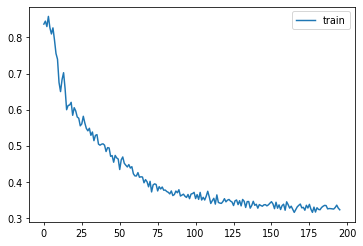

In [ ]:
learn.fit(epochs)

In [ ]:
for o in model.dn.parameters(): o.requires_grad_(True)

In [ ]:
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.316,0,train
0.234,0,eval
0.294,1,train
0.222,1,eval
0.282,2,train
0.221,2,eval
0.275,3,train
0.224,3,eval
0.269,4,train
0.223,4,eval


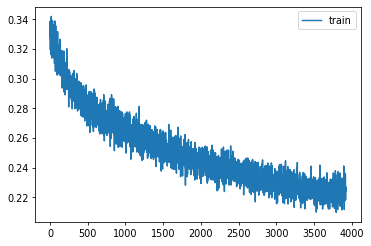

In [ ]:
learn.fit(epochs)

In [ ]:
p,t,inp = learn.capture_preds(inps=True)

loss,epoch,train
0.189,0,eval


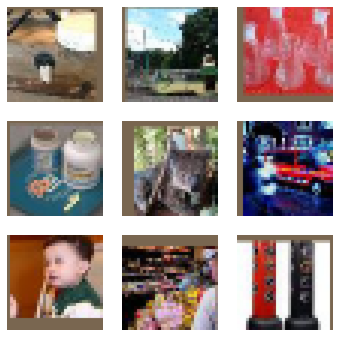

In [ ]:
show_images(denorm(inp[:9]), imsize=2)

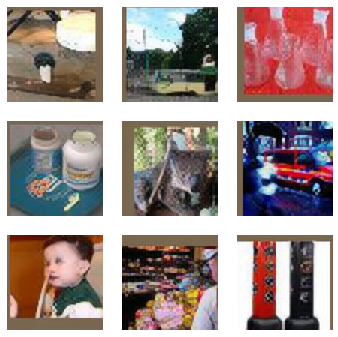

In [ ]:
show_images(denorm(p[:9]), imsize=2)

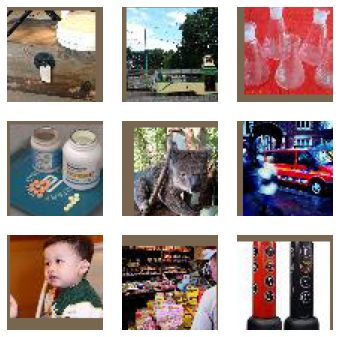

In [ ]:
show_images(denorm(t[:9]), imsize=2)

In [ ]:
torch.save(learn.model, 'models/superres-cross.pkl')
# learn.model = torch.load('models/superres-pcp.pkl').cuda()